In [1]:
!pip install --upgrade  scipy
!pip install --upgrade  scikit-learn

     |████████████████████████████████| 25.9MB 146kB/s 
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.5.2 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
     |████████████████████████████████| 6.9MB 2.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

In [3]:
%tensorflow_version 2.x

In [4]:
import tensorflow as tf
#tf.enable_eager_execution()
print(tf.__version__)

2.2.0


In [5]:
!pip install --upgrade git+https://github.com/titu1994/tfdiffeq.git 

  Cloning https://github.com/titu1994/tfdiffeq.git to /tmp/pip-req-build-a751qo5c
  Running command git clone -q https://github.com/titu1994/tfdiffeq.git /tmp/pip-req-build-a751qo5c
  Created wheel for tfdiffeq: filename=tfdiffeq-0.0.1-py2.py3-none-any.whl size=50528 sha256=b3f6e392dda30b14a96a660237c5de21b76b13269b9c894dc7e532ad52aa675b
  Stored in directory: /tmp/pip-ephem-wheel-cache-85mtjoy1/wheels/1a/fc/26/608bd5ecbf21d23b0e87bb71814d3c031b7c8a5b37fa7aa904
Successfully built tfdiffeq


In [6]:
!pip install pysindy

In [7]:
!pip install tensorflow_probability

In [8]:
%load_ext autoreload
%autoreload 2

In [18]:
from tfdiffeq import odeint
from tfdiffeq import plot_phase_portrait, plot_vector_field, plot_results
from tfdiffeq.bfgs_optimizer import BFGSOptimizer
import pandas as pd

In [10]:
NUM_SAMPLES = 1000
device = 'cpu:0' # These experiments do not require the GPU. Normally, 'gpu:0' if tf.test.is_gpu_available() else 'cpu:0' should be used.

# Force Float 64
tf.keras.backend.set_floatx('float64')

In [11]:
class LotkaVoltera(tf.keras.Model):
  
  def __init__(self, a, b, c, d, **kwargs):
    super().__init__(**kwargs)
    
    self.a, self.b, self.c, self.d = a, b, c, d
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)
    
    dR_dT = self.a * r - self.b * r * f
    dF_dT = -self.c * f + self.d * r * f
    
    return tf.stack([dR_dT, dF_dT])

In [12]:
t = tf.linspace(0., 10., num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([1, 1], dtype=tf.float64)

a = 1.5
b = 1
c = 3
d = 1

In [13]:
%%time

with tf.device(device):
  result = odeint(LotkaVoltera(a, b, c, d), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)
CPU times: user 2.1 s, sys: 39.2 ms, total: 2.14 s
Wall time: 2.28 s


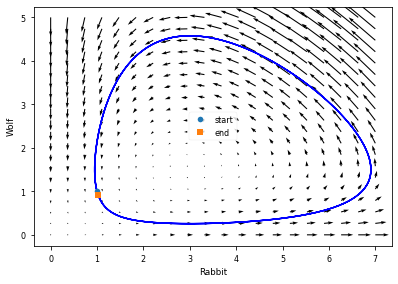

In [14]:
lims = [0, 5]
plot_phase_portrait(LotkaVoltera(a, b, c, d), xlabel='Rabbit', ylabel='Wolf', xlims=[0, 7], ylims=lims)
plot_vector_field(result, xlabel='Rabbit', ylabel='Wolf')

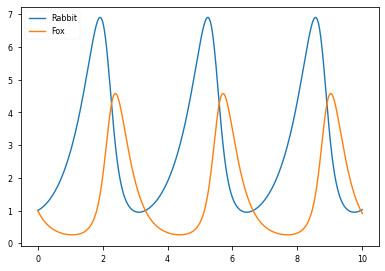

In [15]:
plot_results(t, result, labels=['Rabbit', 'Fox'])

In [72]:
t = tf.linspace(0., 20., num=21)
initial_states = tf.convert_to_tensor([30, 4], dtype=tf.float64)

#a,b,c,d=0.5, 0.02, 0.8, 0.02
a,b,c,d=0.4970243837965384,0.022672841600171096,0.7971518919963235,0.022622014469468894

In [73]:
%%time

with tf.device(device):
  result = odeint(LotkaVoltera(a, b, c, d), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (21, 2)
CPU times: user 993 ms, sys: 20.3 ms, total: 1.01 s
Wall time: 984 ms


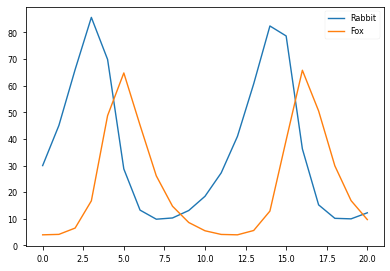

In [74]:
plot_results(t, result, labels=['Rabbit', 'Fox'])

# Universal ODEs

Original Lotke-Volterra system 
>$\frac{\partial R}{\partial T} = aR - bRF \\ \frac{\partial F}{\partial T} = -cF + dRF$

For our system, we set $a=1.5$, $b=1$, $c=3.0$, $d=1$

-------

For Universal ODE formulation of the above,

> We substitute $bRF$ with $U_1(R, F)$ in $\frac{\partial R}{\partial T}$.

> We substitute $bRF$ with $U_2(R, F)$ in $\frac{\partial F}{\partial T}$.

Therefore,
>$\frac{\partial R}{\partial T} = aR - U_1(R, F) \\ \frac{\partial F}{\partial T} = -cF + U_2(R, F)$


In [ ]:
class LotkaVolteraTrainable(tf.keras.Model):
  
  def __init__(self, a, b, c, d, **kwargs):
    super().__init__(**kwargs)
    
    self.a, self.c = a, c

    self.eqn = tf.keras.Sequential([
             tf.keras.layers.Dense(32, activation=tf.nn.swish, input_shape=(2,)),
             tf.keras.layers.Dense(32, activation=tf.nn.swish,),
             tf.keras.layers.Dense(32, activation=tf.nn.swish),
             tf.keras.layers.Dense(2, activation='relu',)   
    ])
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)

    # Neural ODE component
    n_out = self.eqn(tf.reshape(y, [1, 2]))  # [1, 2] -> [1, 2]
    pred1 = n_out[0, 0]
    pred2 = n_out[0, 1]
    
    dR_dT = self.a * r - pred1
    dF_dT = -self.c * f + pred2
    
    return tf.stack([dR_dT, dF_dT])

In [ ]:
t_train = tf.linspace(0., 2., num=30)  # Train for just 2 seconds of input
initial_states_train = tf.convert_to_tensor([1, 1], dtype=tf.float64)

a = 1.5
b = 1
c = 3
d = 1

epochs = 100
initial_learning_rate = 0.01
decay_steps = 100
decay_rate = 0.5

In [ ]:
# Lets see the ground truth sample
%%time

with tf.device(device):
  result_train = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)
  
print("Finished integrating ! Result shape : ", result_train.shape)

Finished integrating ! Result shape :  (30, 2)
CPU times: user 378 ms, sys: 2.82 ms, total: 380 ms
Wall time: 374 ms


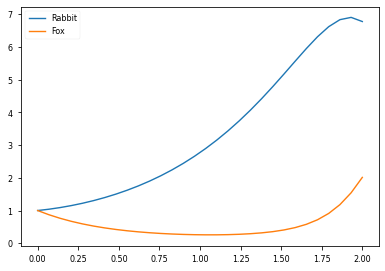

In [ ]:
plot_results(t_train, result_train, labels=['Rabbit', 'Fox'])

# Train a model

We pretrain the model for a few epochs to reduce the loss quickly, and then retrain the model using BFGS to reduce the loss to a small enough tolerance (say $10^{-6}$).

In [ ]:
%%time

with tf.device(device):
  model = LotkaVolteraTrainable(a, b, c, d)

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  print("Computing ground truth...")
  y_real = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train)
      loss = tf.reduce_mean(tf.square(y_real - preds), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()

Computing ground truth...
Ground truth shape : (30, 2)
Epoch 1
Loss : 8.421962522171398
LR : 0.0099309245

Epoch 2
Loss : 2.2960119205530094
LR : 0.009862327

Epoch 3
Loss : 0.29949217288317415
LR : 0.009794203

Epoch 4
Loss : 0.4868180378551776
LR : 0.0097265495

Epoch 5
Loss : 1.2526577811319137
LR : 0.009659363

Epoch 6
Loss : 1.619637765079077
LR : 0.009592641

Epoch 7
Loss : 1.5144941110341756
LR : 0.009526379

Epoch 8
Loss : 1.1328132557292192
LR : 0.009460577

Epoch 9
Loss : 0.6871124588826306
LR : 0.009395227

Epoch 10
Loss : 0.346940138478378
LR : 0.0093303295

Epoch 11
Loss : 0.20680470285313016
LR : 0.00926588

Epoch 12
Loss : 0.2648385532319216
LR : 0.009201876

Epoch 13
Loss : 0.4294528314458957
LR : 0.009138315

Epoch 14
Loss : 0.5740422988227076
LR : 0.009075192

Epoch 15
Loss : 0.6164694778432452
LR : 0.0090125045

Epoch 16
Loss : 0.5491411364288502
LR : 0.00895025

Epoch 17
Loss : 0.4164153125376867
LR : 0.008888427

Epoch 18
Loss : 0.2760740162393521
LR : 0.00882703



In [ ]:
model.save_weights('model_weights/ckpt', save_format='tf')

In [ ]:
model.load_weights('model_weights/ckpt')

## Finetune the model with BFGS

In [ ]:
#from tfdiffeq.bfgs_optimizer import BFGSOptimizer

In [ ]:
tolerance = 1e-6
bfgs_optimizer = BFGSOptimizer(max_iterations=50, tolerance=tolerance)

### Create a wrapper function for the BFGS optimizer 

BFGS optimizer is somewhat different than SGD or ADAM from Tensorflow. It requires a callable function `loss_func`, which accepts the `model` as input and returns a single float value `loss_value`.

```python
loss_value = loss_func(model)
```

The model is generally a `tf.keras.Model` or its subclasses, and we can use external data as inputs if required to obtain a loss value as shown below.

In [ ]:
from tfdiffeq.adjoint import odeint as adjoint_odeint

def loss_wrapper(model):
  # Can use `adjoing_odeint` here as replacement for `adjoint_odeint`
  preds = odeint(model, initial_states_train, t_train, atol=1e-6, rtol=1e-6)
  loss = tf.reduce_mean(tf.square(y_real - preds))
  return loss

In [ ]:
%%time

model = bfgs_optimizer.minimize(loss_wrapper, model)

Iter: 1 loss: 0.039481248791246384
Iter: 2 loss: 0.051695258339139773
Iter: 3 loss: 0.039405697826756556
Iter: 4 loss: 0.036932669574323611
Iter: 5 loss: 0.03693246617957021
Iter: 6 loss: 0.032721308478080011
Iter: 7 loss: 0.12849677951572636
Iter: 8 loss: 0.032710894403882085
Iter: 9 loss: 0.028109023482855659
Iter: 10 loss: 0.10942248624519466
Iter: 11 loss: 0.027947713906822647
Iter: 12 loss: 0.022760031613739247
Iter: 13 loss: 0.022310210925035882
Iter: 14 loss: 0.13453256532172078
Iter: 15 loss: 0.02098480309951305
Iter: 16 loss: 0.10768476371226245
Iter: 17 loss: 0.019670434120606931
Iter: 18 loss: 0.019604602319421072
Iter: 19 loss: 0.017209835998101872
Iter: 20 loss: 0.017336452795288126
Iter: 21 loss: 0.016502087355170926
Iter: 22 loss: 0.01642444180611858
Iter: 23 loss: 0.015946337561465355
Iter: 24 loss: 0.015517133984830296
Iter: 25 loss: 0.0292447337878854
Iter: 26 loss: 0.015517220518829275
Iter: 27 loss: 0.014975077122542622
Iter: 28 loss: 0.014953263723425753
Iter: 29 l

# Save your weights and download them !

In [ ]:
model.save_weights('model_weights/ckpt', save_format='tf')

# Load a new model and load these weights (if you didnt train above)

In [ ]:
import os
import requests

def get_checkpoints():
  if not os.path.exists('model_weights'):
      os.makedirs('model_weights')

  r = requests.get('https://github.com/titu1994/tfdiffeq/releases/download/v0.0.1-pre0/checkpoint')
  with open('./model_weights/checkpoint', 'wb') as f:
    f.write(r.content)

  r = requests.get('https://github.com/titu1994/tfdiffeq/releases/download/v0.0.1-pre0/ckpt.data-00000-of-00001')
  with open('./model_weights/ckpt.data-00000-of-00001', 'wb') as f:
    f.write(r.content)

  r = requests.get('https://github.com/titu1994/tfdiffeq/releases/download/v0.0.1-pre0/ckpt.index')
  with open('./model_weights/ckpt.index', 'wb') as f:
    f.write(r.content)
  
  print("Pretrained checkpoints retrieved !")

In [ ]:
get_checkpoints()

Pretrained checkpoints retrieved !


In [ ]:
model = LotkaVolteraTrainable(a, b, c, d)
model.load_weights('model_weights/ckpt')

# Lets interpolate with our approximate universal ODE !

With a trained Neural ODE that appxoximates the Lotka Voltera system with just 30 samples, lets interpolate within the same timeframe to get a fine solution to the coarse approximate.

In [ ]:
%%time

t_eval = tf.linspace(0., 2, num=1000)  # Re-evaluate for just 2 seconds of input, but 1000 timesteps

with tf.device(device):
    model_results = odeint(model, initial_states, t_eval)
    real_results = odeint(LotkaVoltera(a, b, c, d), initial_states, t_eval)

CPU times: user 1.97 s, sys: 22.1 ms, total: 1.99 s
Wall time: 1.97 s


# Plot the ODE approximation !

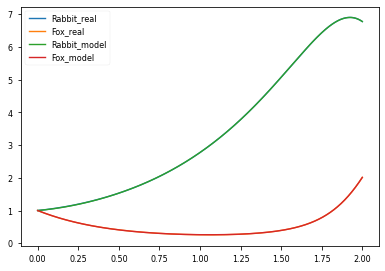

In [ ]:
plot_results(t_eval, real_results, labels=['Rabbit_real', 'Fox_real'])
plot_results(t_eval, model_results, labels=['Rabbit_model', 'Fox_model'])

# Lets try and obtain the underlying equations of this system

In [ ]:
real_results_np = real_results.numpy()
model_preds_np = model_results.numpy()
t_eval_np = t_eval.numpy()

In [ ]:
from pysindy import SINDy
from pysindy import SR3
from pysindy.feature_library.polynomial_library import PolynomialLibrary

# Import this optimizer for Ridge regression !
from tfdiffeq.sindy_utils import STRRidge

# Optimize hyper parameters of SRTRidge and the Polynomial Library

In [ ]:
# sindy_optm = SRTRidge(threshold=0.5, alpha=1.0)
sindy_optm = SR3(threshold=0.1, nu=1.0, max_iter=100)
sindy_library = PolynomialLibrary(degree=10, include_interaction=True,  interaction_only=True)

# Lets fit the SInDy model !

SInDy is short for "Sparse Identification of Non-linear Dynamical Systems" from the paper [Discovering governing equations from data by sparse identification of nonlinear dynamical systems](https://www.pnas.org/content/113/15/3932)

In [ ]:
sindy_model = SINDy(optimizer=sindy_optm, feature_library=sindy_library, discrete_time=False)
sindy_model.fit(model_preds_np, t_eval_np)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=10, interaction_only=True),
      feature_names=['x0', 'x1'], optimizer=SR3(max_iter=100))

# Lets compare with the original equations

>$\frac{\partial R}{\partial T} = aR - bRF \\ \frac{\partial F}{\partial T} = -cF + dRF$

Recall, $a=1.5$, $b=1$, $c=3.0$, $d=1$

We substitute $bRF$ with $U_1(R, F)$ in $\frac{\partial R}{\partial T}$.

We substitute $bRF$ with $U_2(R, F)$ in $\frac{\partial F}{\partial T}$.

--------

We compare the above two equations with the one printed below.

We get $a'=1.498$ which is quite close to $a=1.5$, $c'=2.993$, close to the original $c=3.0$.

The equation below approximates $b'=0.997$, close to the $b=1$ we expect. $d'=0.999$ is a closer approximate to our original $d=1$.



In [ ]:
sindy_model.print()

x0' = 1.498 x0 + -0.997 x0 x1
x1' = -2.993 x1 + 0.999 x0 x1


In [ ]:
sindy_model.coefficients()

array([[ 0.        ,  1.49801949,  0.        , -0.99657202],
       [ 0.        ,  0.        , -2.99258126,  0.99857371]])

In [ ]:
sindy_model.equations()

['1.498 x0 + -0.997 x0 x1', '-2.993 x1 + 0.999 x0 x1']

# Compute the $R^2$ score 

In [ ]:
sindy_model.score(model_preds_np, t_eval_np)

0.9999293714444477

# Finding the correct coefficients for the model

We have the ode framework components which correspond to the neural network modules, but we cant be sure that the parameters found are correctly found by SInDy.

We can refit the model (but now replacing correct components and removing the corresponding neural network component), and try to estimate the parameters from the train set.

In [ ]:
device = 'cpu:0' 

In [63]:
class LotkaVolteraParameters(tf.keras.Model):
  
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    
    # Can also initialize with the values found above for much faster convergence !
    # self.parameters = tf.Variable([1.498, 0.997, 2.993, 0.999], dtype=tf.float64)
    # Next values are for Lynx and Hare
    self.parameters = tf.Variable([0.5, 0.02, 0.8, 0.02], dtype=tf.float64)
#    self.parameters = tf.Variable(tf.random.uniform(shape=[4], dtype=tf.float64))
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)

    # Apply abs, because we want to ensure these parameters are > 0
    params = tf.math.abs(self.parameters)
    a, b, c, d = tf.unstack(params)
    
    dR_dT = a * r - b * r * f
    dF_dT = -c * f + d * r * f
    
    return tf.stack([dR_dT, dF_dT])

In [65]:
#data=pd.read_csv("hudson-bay-lynx-hare.csv",header=1, delim_whitespace=True)
data=pd.read_csv("hudson-bay-lynx-hare.csv")
yobs=data[["Lynx","Hare"]]
y_obs_tmp=yobs.to_numpy()
y_obs=tf.convert_to_tensor(y_obs_tmp,dtype='float64')
len(y_obs[:,0])

21

In [42]:
data

Year  Lynx  Hare
0   1900   4.0  30.0
1   1901   6.1  47.2
2   1902   9.8  70.2
3   1903  35.2  77.4
4   1904  59.4  36.3
5   1905  41.7  20.6
6   1906  19.0  18.1
7   1907  13.0  21.4
8   1908   8.3  22.0
9   1909   9.1  25.4
10  1910   7.4  27.1
11  1911   8.0  40.3
12  1912  12.3  57.0
13  1913  19.5  76.6
14  1914  45.7  52.3
15  1915  51.1  19.5
16  1916  29.7  11.2
17  1917  15.8   7.6
18  1918   9.7  14.6
19  1919  10.1  16.2
20  1920   8.6  24.7

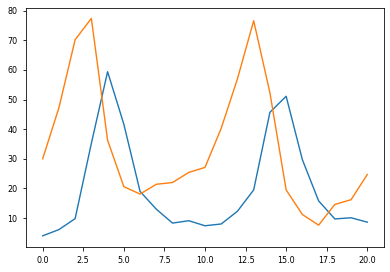

In [66]:
plt.plot(t_train,y_obs[:,0],t_train,y_obs[:,1])

In [ ]:
t_train = tf.linspace(0., 2., num=30)  # Train for just 2 seconds of input
initial_states_train = tf.convert_to_tensor([1, 1], dtype=tf.float64)

a = 1.5
b = 1
c = 3
d = 1

epochs = 25
initial_learning_rate = 0.1
decay_steps = 100
decay_rate = 0.5

In [106]:
%%time

with tf.device(device):
  model = LotkaVolteraParameters()

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  print("Computing ground truth...")
  y_real = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train)
      loss = tf.reduce_mean(tf.square(y_real - preds), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()

Computing ground truth...
Ground truth shape : (21, 2)
Epoch 1
Loss : 100.32090654602152
LR : 0.09930925

Epoch 2
Loss : 87.63697634003715
LR : 0.09862327

Epoch 3
Loss : 76.43466983327974
LR : 0.09794203

Epoch 4
Loss : 66.72221618788991
LR : 0.0972655

Epoch 5
Loss : 58.357187185181935
LR : 0.09659363

Epoch 6
Loss : 51.16492494485719
LR : 0.09592641

Epoch 7
Loss : 44.977387510234074
LR : 0.0952638

Epoch 8
Loss : 39.64506443618193
LR : 0.094605766

Epoch 9
Loss : 35.039182514183736
LR : 0.093952276

Epoch 10
Loss : 31.050578932236487
LR : 0.0933033

Epoch 11
Loss : 27.587549011169738
LR : 0.09265881

Epoch 12
Loss : 24.572844441909215
LR : 0.09201877

Epoch 13
Loss : 21.94162680975919
LR : 0.09138315

Epoch 14


KeyboardInterrupt: ignored

In [ ]:
tolerance = 1e-6
bfgs_optimizer = BFGSOptimizer(max_iterations=50, tolerance=tolerance)

In [111]:
t_train = tf.linspace(0., 20., num=21)  # Train for just 2 seconds of input
initial_states_train = tf.convert_to_tensor([30, 4], dtype=tf.float64)


epochs = 55
initial_learning_rate = 0.1
decay_steps = 100
decay_rate = 0.5

In [112]:
%%time

with tf.device(device):
  model = LotkaVolteraParameters()

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adadelta(learning_rate)

  print("Computing ground truth...")
#  y_real = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)
  y_real = y_obs

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train)
      loss = tf.reduce_mean(tf.square(y_real - preds), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()

Computing ground truth...
Ground truth shape : (21, 2)
Epoch 1
Loss : 1360.8579086380937
LR : 0.09930925

Epoch 2
Loss : 1338.1916714325437
LR : 0.09862327

Epoch 3
Loss : 1316.5511920420936
LR : 0.09794203

Epoch 4
Loss : 1296.069659026235
LR : 0.0972655

Epoch 5
Loss : 1276.7461355975724
LR : 0.09659363

Epoch 6
Loss : 1258.5332457903564
LR : 0.09592641

Epoch 7
Loss : 1241.3670768798875
LR : 0.0952638

Epoch 8
Loss : 1225.178464122218
LR : 0.094605766

Epoch 9
Loss : 1209.8992905963994
LR : 0.093952276

Epoch 10
Loss : 1195.4643851782225
LR : 0.0933033

Epoch 11
Loss : 1181.8127572512192
LR : 0.09265881

Epoch 12
Loss : 1168.8878396765278
LR : 0.09201877

Epoch 13
Loss : 1156.637545176888
LR : 0.09138315

Epoch 14
Loss : 1145.0137223871427
LR : 0.090751916

Epoch 15
Loss : 1133.9723730901776
LR : 0.09012505

Epoch 16
Loss : 1123.473115556047
LR : 0.089502506

Epoch 17
Loss : 1113.4788160601624
LR : 0.08888427

Epoch 18
Loss : 1103.9554556633236
LR : 0.0882703

Epoch 19
Loss : 1094.8

In [86]:
tolerance = 1e-1
bfgs_optimizer = BFGSOptimizer(max_iterations=50, tolerance=tolerance)

In [91]:
def loss_wrapper(model):
  # Can use `adjoing_odeint` here as replacement for `adjoint_odeint`
  preds = odeint(model, initial_states_train, t_train, atol=1e-8, rtol=1e-8)
  loss = tf.reduce_mean(tf.square(y_real - preds))
  return loss

In [92]:
model = bfgs_optimizer.minimize(loss_wrapper, model)

Exception ignored in: <bound method EagerResourceDeleter.__del__ of <tensorflow.python.ops.resource_variable_ops.EagerResourceDeleter object at 0x7f21bc742c88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py", line 280, in __del__
    def __del__(self):
KeyboardInterrupt


KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


KeyboardInterrupt: ignored

## Lets print the learned parameters of this ODE

In [113]:
params = tf.math.abs(model.trainable_variables[0])
params.numpy().tolist()

[0.494555407395403,
 0.02443678907946571,
 0.7949255763294267,
 0.024317046388837187]

# Finally, lets extrapolate the derived ODE !

In [ ]:
%%time

a_dash = 1.4999991609739252
b_dash = 0.9999962444516388
c_dash = 2.999976055259427
d_dash = 0.9999915353099846

t_extrapolate = tf.linspace(0., 10.0, num=1000)  # Train for just 3 seconds of input
initial_states_extrapolate = tf.convert_to_tensor([1, 1], dtype=tf.float64)

with tf.device(device):
    extrapolation_model = LotkaVoltera(a_dash, b_dash, c_dash, d_dash)
    extrapolated_results = odeint(extrapolation_model, initial_states_extrapolate, t_extrapolate)
    real_results = odeint(LotkaVoltera(a, b, c, d), initial_states_extrapolate, t_extrapolate)

CPU times: user 5.49 s, sys: 78.2 ms, total: 5.57 s
Wall time: 5.4 s


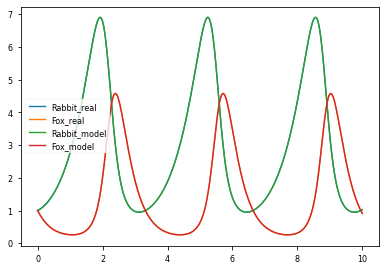

In [ ]:
plot_results(t_extrapolate, real_results, labels=['Rabbit_real', 'Fox_real'])
plot_results(t_extrapolate, extrapolated_results, labels=['Rabbit_model', 'Fox_model'])

In [114]:
%%time

a_dash ,b_dash ,c_dash,d_dash= 0.494555407395403,0.02443678907946571,0.7949255763294267,0.024317046388837187


t_extrapolate = tf.linspace(0., 24.0, num=100)  # Train for just 3 seconds of input
initial_states_extrapolate = tf.convert_to_tensor([30, 4], dtype=tf.float64)

with tf.device(device):
    extrapolation_model = LotkaVoltera(a_dash, b_dash, c_dash, d_dash)
    extrapolated_results = odeint(extrapolation_model, initial_states_extrapolate, t_extrapolate)
    real_results = y_obs
#    real_results = odeint(LotkaVoltera(a, b, c, d), initial_states_extrapolate, t_extrapolate)

CPU times: user 1.16 s, sys: 26.9 ms, total: 1.18 s
Wall time: 1.15 s


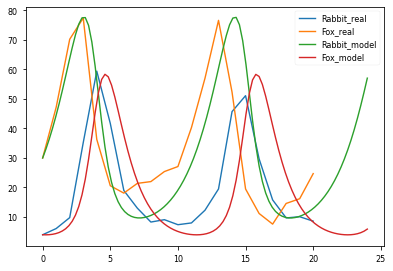

In [115]:
plot_results(t_train, real_results, labels=['Rabbit_real', 'Fox_real'])
plot_results(t_extrapolate, extrapolated_results, labels=['Rabbit_model', 'Fox_model'])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

NUM_SAMPLES=89
# a = 0.28
# b = 0.2
# c = .01

a = 1.
b = 0.07
c = .01

mu = 0.000046948
nu = 0.00001589
# mu = 0.0
# nu = 0.0
N  = 128932753
S0 = (N-4)/N
I0 = 4/N
R0 = 0

t = tf.linspace(0., 89., num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([S0, I0,R0], dtype=tf.float64)

In [ ]:
class SIR(tf.keras.Model):
  
  def __init__(self, a, b, c, **kwargs):
    super().__init__(**kwargs)
    
    self.a, self.b, self.c = a, b, c
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f,g= tf.unstack(y)


    dS_dT = mu - ( self.a*f + nu   )*r   
    dI_dT = ( self.a*f + nu   )*r -(self.b + nu)*f     
    dP_dT = self.c*f
    
    return tf.stack([dS_dT,dI_dT,dP_dT])

In [ ]:
%%time

with tf.device(device):
#     result = odeint(SIR(a, b, c), initial_states, t,method='rk4')
#     result = odeint(SIR(a, b, c), initial_states, t,method='adams')
     result = odeint(SIR(a, b, c), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (89, 3)
CPU times: user 880 ms, sys: 23.2 ms, total: 903 ms
Wall time: 887 ms


In [ ]:
np.shape(result)

TensorShape([89, 3])

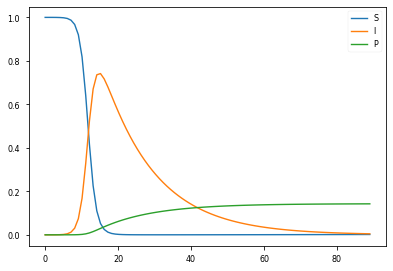

In [ ]:
plot_results(t, result, labels=['S', 'I','P'])

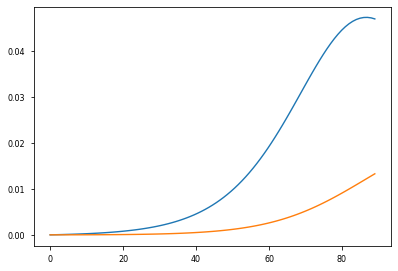

In [ ]:
plt.plot(t, result[:,1], t, result[:,2])

In [ ]:
class SIRParameters(tf.keras.Model):
  
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

    # Can also initialize with the values found above for much faster convergence !
    self.parameters = tf.Variable([.1, 2., .01], dtype=tf.float64)
#    self.parameters = tf.Variable(tf.random.uniform(shape=[3], minval=0, maxval=1,dtype=tf.float64))
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f,g = tf.unstack(y)

    # Apply abs, because we want to ensure these parameters are > 0
    params = tf.math.abs(self.parameters)
    a, b, c = tf.unstack(params)

    dS_dT = mu - ( a*f + nu   )*r   
    dI_dT = ( a*f + nu   )*r -(b + nu)*f     
    dP_dT = c*f
    
    return tf.stack([dS_dT,dI_dT,dP_dT])    

In [ ]:
epochs = 50
initial_learning_rate = 0.1
decay_steps = 100
decay_rate = 0.5


t_train = tf.linspace(0., 89., num=89)  # Train for the days of the pandemic
initial_states_train = tf.convert_to_tensor([S0, I0,R0], dtype=tf.float64)
#initial_states_train = tf.convert_to_tensor([1, 1], dtype=tf.float64)

In [ ]:
data=pd.read_csv("covidMexico.csv")
yobs=data[["New cases (HUC)","Deaths (HUC)"]]
y_obs=yobs.to_numpy()
y_real=tf.convert_to_tensor(y_obs, dtype=tf.float64)

In [ ]:
%%time

with tf.device(device):
  model = SIRParameters()

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adadelta(learning_rate)

  print("Computing ground truth...")
#  y_real = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)
#  y_real = tf.convert_to_tensor(yobs, dtype=tf.float64)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train)
      y_hat = tf.transpose(tf.stack([preds[:,1],preds[:,2]]))
      loss = tf.reduce_mean(tf.square(y_real - N*y_hat), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()

Computing ground truth...
Ground truth shape : (89, 2)
Epoch 1
Loss : 562944.8227157246
LR : 0.09930925

Epoch 2
Loss : 559623.4237287353
LR : 0.09862327

Epoch 3
Loss : 556378.1000889831
LR : 0.09794203

Epoch 4
Loss : 553231.4799949161
LR : 0.0972655

Epoch 5
Loss : 550192.1745754066
LR : 0.09659363

Epoch 6
Loss : 547263.0229315172
LR : 0.09592641

Epoch 7
Loss : 544444.0815240839
LR : 0.0952638

Epoch 8
Loss : 541733.8289647811
LR : 0.094605766

Epoch 9
Loss : 539129.8253914582
LR : 0.093952276

Epoch 10
Loss : 536629.1759686145
LR : 0.0933033

Epoch 11
Loss : 534228.8315035454
LR : 0.09265881

Epoch 12
Loss : 531925.32904027
LR : 0.09201877

Epoch 13
Loss : 529715.1112340107
LR : 0.09138315

Epoch 14
Loss : 527594.6065631794
LR : 0.090751916

Epoch 15
Loss : 525560.2731484404
LR : 0.09012505

Epoch 16
Loss : 523608.62950647296
LR : 0.089502506

Epoch 17
Loss : 521736.2743262861
LR : 0.08888427

Epoch 18
Loss : 519939.89889077615
LR : 0.0882703

Epoch 19
Loss : 518216.29857275565
L

In [ ]:
# tolerance = 1e-1
# bfgs_optimizer = BFGSOptimizer(max_iterations=50, tolerance=tolerance)

In [ ]:
# def loss_wrapper(model):
#   # Can use `adjoing_odeint` here as replacement for `adjoint_odeint`
#   preds = odeint(model, initial_states_train, t_train, atol=1e-3, rtol=1e-3)
#   y_hat = tf.transpose(tf.stack([preds[:,1],preds[:,2]]))
#   loss = tf.reduce_mean(tf.square(y_real - N*y_hat))
#   return loss

In [ ]:
# model = bfgs_optimizer.minimize(loss_wrapper, model)

In [ ]:
params = tf.math.abs(model.trainable_variables[0])
params.numpy().tolist()

[0.09600440536619413, 2.003998257662741, 0.005456481836558528]

In [ ]:
a_dash = 0.2944932012466365
b_dash = 0.01259975623864584
c_dash = 0.014807657555633421


t_extrapolate = tf.linspace(0., 120, num=1000)  # Train for just 3 seconds of input
initial_states_extrapolate = tf.convert_to_tensor([S0, I0,R0], dtype=tf.float64)
#initial_states_extrapolate = tf.convert_to_tensor([1, 1], dtype=tf.float64)

with tf.device(device):
    extrapolation_model = SIR(a_dash, b_dash, c_dash)
    extrapolated_results = odeint(extrapolation_model, initial_states_extrapolate, t_extrapolate)
#    real_results = odeint(SIR(a, b, c), initial_states_extrapolate, t_extrapolate)

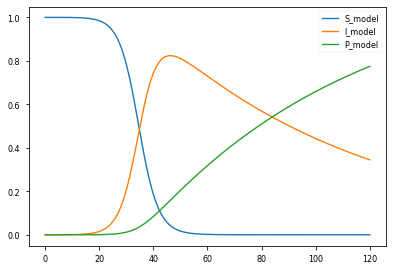

In [ ]:
#plot_results(t_extrapolate, real_results, labels=['S_real', 'Fox_real'])
plot_results(t_extrapolate, extrapolated_results, labels=['S_model', 'I_model','P_model'])

In [ ]:
a_dash, b_dash,c_dash=  0.10138332655995629, 5.5986186195375165, 0.007058885499027403


t_extrapolate = tf.linspace(0., 120, num=1000)  # Train for just 3 seconds of input
initial_states_extrapolate = tf.convert_to_tensor([S0, I0,R0], dtype=tf.float64)
#initial_states_extrapolate = tf.convert_to_tensor([1, 1], dtype=tf.float64)

with tf.device(device):
    extrapolation_model = SIR(a_dash, b_dash, c_dash)
    extrapolated_results = odeint(extrapolation_model, initial_states_extrapolate, t_extrapolate)
#    real_results = odeint(SIR(a, b, c), initial_states_extrapolate, t_extrapolate)

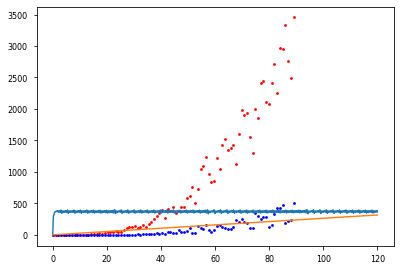

In [ ]:
plt.plot(t_train, y_obs[:,0],'r.', t_train, y_obs[:,1],'b.')
plt.plot(t_extrapolate, N*extrapolated_results[:,1], 
         t_extrapolate, N*extrapolated_results[:,2])